In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
tf.config.run_functions_eagerly(True)

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
import os

# Ocultar advertencias de TensorFlow y otros warnings innecesarios
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Oculta logs de TensorFlow (0 = todos, 1 = INFO, 2 = WARNING, 3 = ERROR)
warnings.filterwarnings("ignore", category=UserWarning)  # Oculta warnings de Python

# Desactivar ejecución ansiosa (si no la necesitas)
tf.config.run_functions_eagerly(False)


In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
path = "/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/2_Data_Processing/normalizing_data/normalized_data.csv"
data = pd.read_csv(path)
print(data.head())

# Get number of rows and columns
num_rows, num_cols = data.shape

print(f"Number of records (rows): {num_rows}")
print(f"Number of columns: {num_cols}")

# Optional: Display column names
print("\nColumn names:")
print(data.columns.tolist())

    parking      area   stories  bathrooms  bedrooms  KPI_Area_per_Furnishing  \
0  2.567042  1.255316  1.996927   1.953795  2.070217                 2.982922   
1  4.164883  2.095150  3.246031   5.410684  2.070217                 3.690541   
2  2.567042  2.640497  0.747822   1.953795  0.640133                -0.426518   
3  4.164883  1.298944  0.747822   1.953795  2.070217                 3.019681   
4  2.567042  1.255316  0.747822   0.225351  2.070217                 2.982922   

   KPI_AirConditioning_Area_Ratio  KPI_Area_per_SemiFurnished  \
0                        3.728447                   -0.380668   
1                        4.566423                   -0.380668   
2                       -0.309069                    4.664127   
3                        3.771979                   -0.380668   
4                        3.728447                   -0.380668   

   KPI_Bathrooms_per_Furnishing  KPI_Area_per_Guestroom  \
0                      2.782468               -0.216708   
1   

In [24]:
X = data.drop(columns=['price'])  # Variables predictoras
y = data['price']  # Variable objetivo

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dropout

def build_model(optimizer_name='SGD'):
    optimizers_dict = {
        'Adam': Adam(learning_rate=0.001),
        'SGD': SGD(learning_rate=0.001, momentum=0.9),
        'RMSprop': RMSprop(learning_rate=0.001),
        'Adagrad': Adagrad(learning_rate=0.001),
        'Adadelta': Adadelta(learning_rate=1.0),
        'Adamax': Adamax(learning_rate=0.002),
        'Nadam': Nadam(learning_rate=0.001)
    }

    if optimizer_name not in optimizers_dict:
        raise ValueError(f"Optimizador {optimizer_name} no reconocido. Opciones válidas: {list(optimizers_dict.keys())}")

    optimizer = optimizers_dict[optimizer_name]

    model = Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        # layers.Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        # layers.Dropout(0.4),  # Dropout aumentado
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        layers.Dropout(0.2),  # Dropout aumentado
        layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        layers.Dropout(0.2),  # Dropout en cada capa para reducir sobreajuste
        layers.Dense(24, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        layers.Dropout(0.2),  # Dropout en cada capa
        layers.Dense(1)  # Capa de salida
    ])
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [35]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

# Definir validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Lista de optimizadores a probar
optimizers = ['Adam', 'SGD', 'Adadelta']

# Diccionario para almacenar resultados
results = {}

early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

for opt_name in optimizers:
    fold_mae = []

    print(f"Entrenando con el optimizador: {opt_name}")

    for train_idx, val_idx in kfold.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        try:
            # Crear un nuevo modelo con el optimizador especificado
            model = build_model(optimizer_name=opt_name)

            # Entrenar el modelo
            history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=24,
                                validation_data=(X_val_fold, y_val_fold), verbose=0,
                                callbacks=[early_stopping])

            # Evaluar el modelo
            val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
            fold_mae.append(val_mae)

        except ValueError as e:
            print(f"Error con optimizador {opt_name}: {e}")
            continue  # Saltar a la siguiente iteración si hay un error

    # Guardar el MAE promedio en los resultados solo si hubo evaluaciones válidas
    if fold_mae:
        results[opt_name] = np.mean(fold_mae)
    else:
        results[opt_name] = float('inf')  # Asignar un valor alto si no se pudo entrenar

print('============================================================')
# Imprimir los resultados de validación cruzada
print("\nResultados de Validación Cruzada (MAE promedio):")
for opt, mae in results.items():
    print(f"{opt}: {mae:.4f}")
print('============================================================')
# Seleccionar el mejor optimizador
best_optimizer_name = min(results, key=results.get)
print(f"\nMejor optimizador seleccionado: {best_optimizer_name}")
print('============================================================')


Entrenando con el optimizador: Adam


KeyboardInterrupt: 

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Elegir el mejor optimizador basado en el menor MAE promedio
# best_optimizer_name = min(results, key=results.get)
best_optimizer_name = 'SGD'
print(f"Mejor optimizador seleccionado: {best_optimizer_name}")

# Construir y entrenar el modelo final con el mejor optimizador
model = build_model(optimizer_name=best_optimizer_name)

Mejor optimizador seleccionado: SGD


In [37]:
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=32,
                    validation_split=0.2, verbose=1, callbacks=[
                        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
                        # Puedes agregar más callbacks como TensorBoard si es necesario
                    ])

Epoch 1/250


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 5.7735 - mae: 0.2372 - val_loss: 5.4467 - val_mae: 0.1489 - learning_rate: 0.0010
Epoch 2/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3805 - mae: 0.1710 - val_loss: 5.0893 - val_mae: 0.1109 - learning_rate: 0.0010
Epoch 3/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0186 - mae: 0.1330 - val_loss: 4.7567 - val_mae: 0.0964 - learning_rate: 0.0010
Epoch 4/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6864 - mae: 0.1183 - val_loss: 4.4403 - val_mae: 0.0904 - learning_rate: 0.0010
Epoch 5/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3706 - mae: 0.1066 - val_loss: 4.1384 - val_mae: 0.0889 - learning_rate: 0.0010
Epoch 6/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0700 - mae: 0.1024 - val_loss: 3.8497 - val_mae: 0.0888 - learning_rate: 0.0010
Epoch 7/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7818 - mae: 0.0944 - val_loss: 3.5740 - val_mae: 0.0888 - learning_rate: 0.0010
Epoch 8/250
61/61 ━━━━━━

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Crear el escalador para desnormalizar la variable objetivo (precio)
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Hacer las predicciones del modelo sobre los datos de entrenamiento y prueba
y_pred_train = model.predict(X_train_scaled)  # Predicciones para el conjunto de entrenamiento
y_pred_test = model.predict(X_test_scaled)    # Predicciones para el conjunto de prueba

# Desnormalizar las predicciones
y_pred_train_real = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_real = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1))

# Desnormalizar los valores reales
y_train_real = scaler_y.inverse_transform(y_train.values.reshape(-1, 1))
y_test_real = scaler_y.inverse_transform(y_test.values.reshape(-1, 1))

# Calcular métricas sobre los valores desnormalizados
mae_train_real = mean_absolute_error(y_train_real, y_pred_train_real)
mae_test_real = mean_absolute_error(y_test_real, y_pred_test_real)

rmse_train_real = np.sqrt(mean_squared_error(y_train_real, y_pred_train_real))
rmse_test_real = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))

r2_train_real = r2_score(y_train_real, y_pred_train_real)
r2_test_real = r2_score(y_test_real, y_pred_test_real)

# Calcular el RMSE como porcentaje de la media de los datos de prueba desnormalizados
mean_value_real = np.mean(y_test_real)
rmse_percentage_real = (rmse_test_real / mean_value_real) * 100

# Imprimir las métricas desnormalizadas
print("\nMétricas de Entrenamiento (desnormalizadas):")
print(f'MAE: {mae_train_real:.4f}')
print(f'RMSE: {rmse_train_real:.4f}')
print(f'R²: {r2_train_real:.4f}')

print("\nMétricas de Prueba (desnormalizadas):")
print(f'MAE: {mae_test_real:.4f}')
print(f'RMSE: {rmse_test_real:.4f}')
print(f'R²: {r2_test_real:.4f}')

if rmse_percentage_real > 15:
    print(f'El RMSE es superior al 15% de la media: {rmse_percentage_real:.2f}%')


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir y ajustar el scaler_y con los datos originales de entrenamiento
scaler_y = StandardScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))  # Ajustar el scaler usando los datos originales de entrenamiento

# Realizar las predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Revertir la normalización de las predicciones
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Revertir la normalización de los valores reales
y_true_original = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Verificar los primeros valores desnormalizados
print("Primeros 5 valores reales:", y_true_original[:5])
print("Primeros 5 valores predichos:", y_pred_original[:5])

# Calcular métricas
mae_original = mean_absolute_error(y_true_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
r2_original = r2_score(y_true_original, y_pred_original)

# Calcular RMSE en porcentaje (usando valor absoluto de la media)
rmse_percentage = (rmse_original / np.abs(np.mean(y_true_original))) * 100

# Mostrar métricas
print("Métricas en el dominio original:")
print(f"MAE: {mae_original:.4f}")
print(f"RMSE: {rmse_original:.4f}")
print(f"RMSE %: {rmse_percentage:.2f}%")
print(f"R²: {r2_original:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Primeros 5 valores reales: [0.3010262  0.30229433 0.27270863 0.29086294 0.27186582]
Primeros 5 valores predichos: [0.29721293 0.29721293 0.29721293 0.29721293 0.29721293]
Métricas en el dominio original:
MAE: 0.0149
RMSE: 0.0197
RMSE %: 6.65%
R²: -0.0004


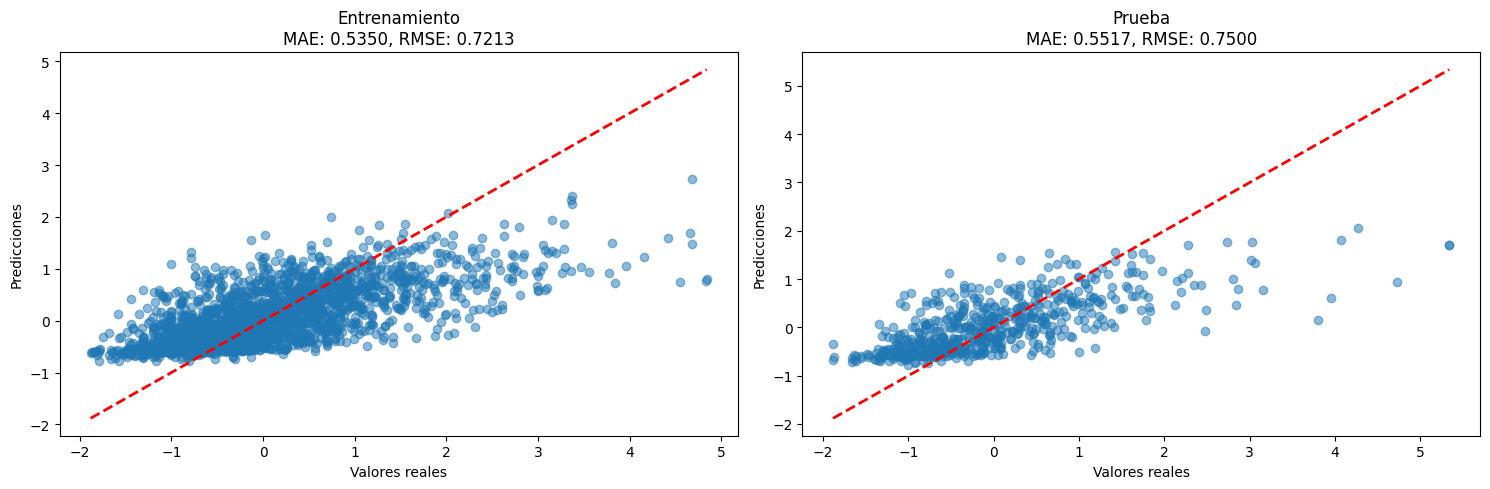

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Entrenamiento\nMAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}')

plt.subplot(122)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Prueba\nMAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}')

plt.tight_layout()
plt.show()